### Preprocessing Sensor Data:
- Load raw data
- Resample & align
- Clean missing / invalid values  
- Scale features
- Optional features
- Save cleaned data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.preprocessing import StandardScaler

path_file = Path.cwd().parent / Path("data/merged_data")
output_path = Path.cwd().parent / Path("data/processed_data")

if not output_path.exists():
    output_path.mkdir(parents=True, exist_ok=True)

sensors_to_explore = [
    'value_Luftfeuchte',
    'value_Lautstärke',
    'value_Temperatur',
       ]
stations_to_explore = [
    'home_Klinga',
    'Stadtteilbüro_Siemensstadt',
    'PANGAEAs_SenseBox',
    'Station_Kaiser',
    'Schnus_Sense_Box'
       ]

n_rows = len(sensors_to_explore)
n_cols = len(stations_to_explore)

dataframes = {}

for file_path in path_file.iterdir():
    file_name = str(file_path.name.split(".")[0])

    if file_name not in stations_to_explore:
        continue
    print(file_name)

    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    df.set_index('timestamp', inplace=True)
    dataframes[file_name] = df

print(df.columns)

PANGAEAs_SenseBox
Station_Kaiser
home_Klinga
Schnus_Sense_Box
Stadtteilbüro_Siemensstadt
Index(['value_PM2.5', 'value_Luftfeuchte', 'value_UV-Intensität', 'value_PM10',
       'value_Lautstärke', 'value_Temperatur', 'value_Beleuchtungsstärke'],
      dtype='object')


## Delete unecessary colunns:

In order to stick to the task and to not blow this project i decided to drop unecessary columns and just keep "humidity", "temperature" and "sound volume".

In [2]:
del_columns = [c for c in df.columns if c not in sensors_to_explore]

for df in dataframes.values():
    for c in del_columns:
        if c in df.columns:
            df.drop(c, axis=1, inplace=True)


## Filling Missing Values

For temperature and humidity interpolation and for sound volume ffill. Interpolation does not work for the humidity column, since it just refills the same values. I decided to keep the corrupted dat and flag it as an anomily.

In [3]:
column = 'value_Luftfeuchte'

def remove_stuck_values(df, column, min, max, min_consecutive):
    df_copy = df.copy()
    df_copy.fillna(method='ffill', inplace=True)
    mask = (df_copy[column] >= max) | (df_copy[column] <= min)

    run_id = (mask != mask.shift()).cumsum()
    run_lengths = mask.groupby(run_id).transform('sum')

    stuck = mask & (run_lengths >= min_consecutive)
    count = stuck.sum()

    df.loc[stuck, column] = None
    print(f"[{column}] removed {count} stuck values below {min } or above {max} (runs ≥ {min_consecutive})")
    
    return df

def flag_flatline_runs(df, column, min, max, min_consecutive, flag_name=None):
    # mask = df[column] == value
    df_copy = df.copy()
    df_copy.fillna(method='ffill', inplace=True)
    mask = (df_copy[column] >= max) | (df_copy[column] <= min)
    
    run_id = (mask != mask.shift()).cumsum()
    run_lengths = mask.groupby(run_id).transform('sum')

    flatline = mask & (run_lengths >= min_consecutive)
    
    if flag_name is None:
        flag_name = f"{column}_flatline_flag"

    df[flag_name] = flatline.astype(int)
    
    print(f"[{column}] flagged {flatline.sum()} flatline points alues below {min } or above {max} (runs ≥ {min_consecutive})")
    return df

# Remove stuck 100% humidity if it lasts for 6+ hours (360 samples at 1-min frequency)
for name, df in dataframes.items():
    print(f"Processing {name}")
    # dataframes[name] = remove_stuck_values(df, 'value_Luftfeuchte', min= 1.,max=99., min_consecutive=180)
    dataframes[name] = flag_flatline_runs(df, 'value_Luftfeuchte', min= 1.,max=99., min_consecutive=180) 
     
    if column in df.columns:
        print(f"  Checking {column}: unique values = {df[column].nunique()}, min = {df[column].min()}, max = {df[column].max()}")




Processing PANGAEAs_SenseBox
[value_Luftfeuchte] flagged 1946 flatline points alues below 1.0 or above 99.0 (runs ≥ 180)
  Checking value_Luftfeuchte: unique values = 8648, min = 0.0, max = 97.04
Processing Station_Kaiser
[value_Luftfeuchte] flagged 2907 flatline points alues below 1.0 or above 99.0 (runs ≥ 180)
  Checking value_Luftfeuchte: unique values = 6817, min = 13.03, max = 99.99
Processing home_Klinga
[value_Luftfeuchte] flagged 9837 flatline points alues below 1.0 or above 99.0 (runs ≥ 180)
  Checking value_Luftfeuchte: unique values = 709, min = 27.6, max = 100.0
Processing Schnus_Sense_Box
[value_Luftfeuchte] flagged 9041 flatline points alues below 1.0 or above 99.0 (runs ≥ 180)
  Checking value_Luftfeuchte: unique values = 24700, min = 25.17, max = 99.99
Processing Stadtteilbüro_Siemensstadt
[value_Luftfeuchte] flagged 0 flatline points alues below 1.0 or above 99.0 (runs ≥ 180)
  Checking value_Luftfeuchte: unique values = 7471, min = 9.14, max = 99.99


/tmp/ipykernel_104907/3081197104.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy.fillna(method='ffill', inplace=True)
/tmp/ipykernel_104907/3081197104.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy.fillna(method='ffill', inplace=True)
/tmp/ipykernel_104907/3081197104.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy.fillna(method='ffill', inplace=True)
/tmp/ipykernel_104907/3081197104.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy.fillna(method='ffill', inplace=True)
/tmp/ipykernel_104907/3081197104.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will

In [4]:
fill_strategies = {
    'value_PM2.5': lambda s: s.interpolate(method='time'),
    'value_PM10': lambda s: s.interpolate(method='time'),
    'value_Temperatur': lambda s: s.interpolate(method='time'),
    'value_Luftfeuchte': lambda s: s.interpolate(method='time'),
    # 'value_Luftfeuchte': lambda s: s,
    'value_Beleuchtungsstärke': lambda s: s.interpolate(method='time'),
    'value_UV-Intensität': lambda s: s.fillna(method='ffill').fillna(method='bfill'),
    'value_Lautstärke': lambda s: s.fillna(method='ffill').fillna(method='bfill'),
}

for df_name, df in dataframes.items():
    for sensor_name, method in fill_strategies.items():
        if sensor_name not in df.columns:
            continue
        df[sensor_name] = method(df[sensor_name])  
        dataframes[df_name] = df 
    print(f"Any missing values left for {df_name}:  {df.isnull().any().any()}")

Any missing values left for PANGAEAs_SenseBox:  False
Any missing values left for Station_Kaiser:  False
Any missing values left for home_Klinga:  False
Any missing values left for Schnus_Sense_Box:  False
Any missing values left for Stadtteilbüro_Siemensstadt:  False


/tmp/ipykernel_104907/279232964.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  'value_Lautstärke': lambda s: s.fillna(method='ffill').fillna(method='bfill'),
/tmp/ipykernel_104907/279232964.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  'value_Lautstärke': lambda s: s.fillna(method='ffill').fillna(method='bfill'),
/tmp/ipykernel_104907/279232964.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  'value_Lautstärke': lambda s: s.fillna(method='ffill').fillna(method='bfill'),
/tmp/ipykernel_104907/279232964.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  'value_Lautstärke': lambda s: s.fillna(method='ffill').fillna(method='b

I decided to do not interpolate the missing values for humidity, because filling methods would just introduce the same flat line that i tried to get rid of. Most modern ML algrotihm handle missing data quite well

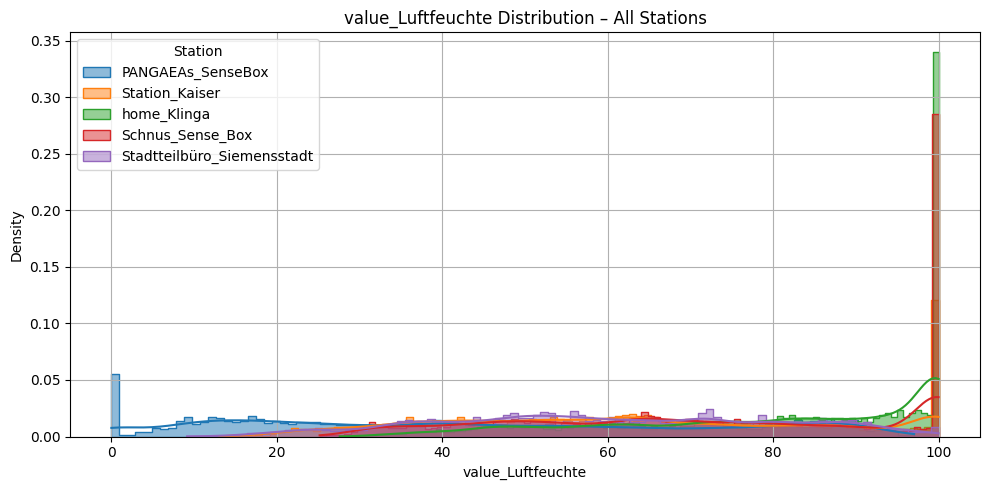

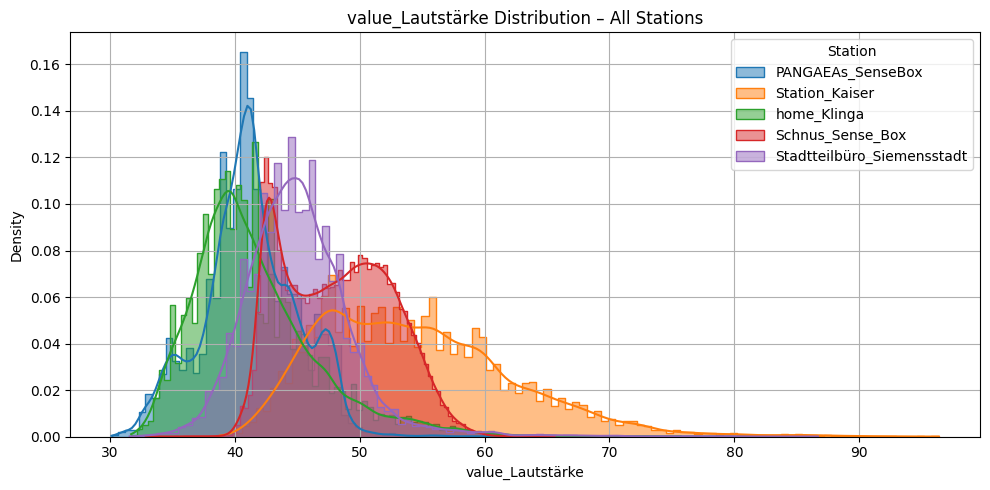

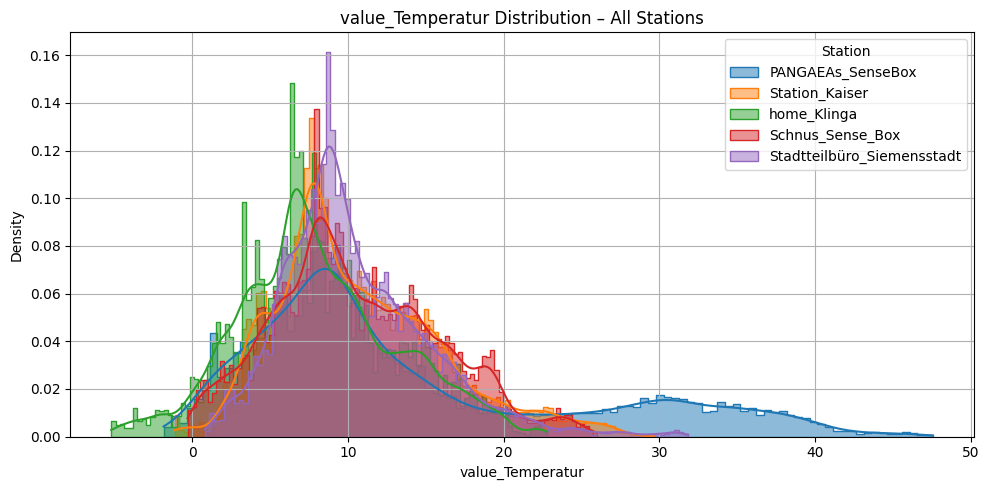

In [5]:
for sensor in sensors_to_explore:
    plt.figure(figsize=(10, 5))
    
    for name, df in dataframes.items():
        if sensor in df.columns:
            sns.histplot(df[sensor], kde=True, label=name, stat="density", bins=100, element="step")
    
    plt.title(f"{sensor} Distribution – All Stations")
    plt.xlabel(sensor)
    plt.ylabel("Density")
    plt.legend(title="Station")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Feature Engineering

In [6]:
def add_lag_features(df, columns, lags=[1, 5, 10]):
    for col in columns:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

In [7]:
# for df in dataframes.values(): 
#     # Add time-based features
#     df['hour'] = df.index.hour
#     df['minute'] = df.index.minute
#     df['weekday'] = df.index.weekday  # 0 = Monday
#     df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
#     df['is_daylight'] = ((df['hour'] >= 6) & (df['hour'] <= 20)).astype(int)
    
#     # Add rolling statistics
#     window = 10  # e.g., 10 minutes

#     for col in ['value_Temperatur', 'value_Luftfeuchte']:
#         df[f'{col}_rolling_mean'] = df[col].rolling(window=window, min_periods=1).mean()
#         df[f'{col}_rolling_std'] = df[col].rolling(window=window, min_periods=1).std()

#         #Add differnece deltas

#         df[f'{col}_diff'] = df[col].diff()

#     # Feature engineering for 'value_Lautstärke' 
#     df['sound_bin'] = pd.cut(df['value_Lautstärke'], bins=[0, 30, 60, 90, 120], labels=["very quiet", "quiet", "normal", "loud"])

#     df['sound_high'] = (df['value_Lautstärke'] > 100).astype(int)
#     df['sound_silent'] = (df['value_Lautstärke'] < 10).astype(int)
    
#     # Add lag features
#     df = add_lag_features(df, ['value_Luftfeuchte', 'value_Temperatur', 'value_Lautstärke'], lags=[1, 5, 10])
#     # Add flatline flags
#     df = flag_flatline_runs(df, 'value_Lautstärke', min=0, max=120, min_consecutive=60, flag_name='Lautstärke_flatline_flag')
from predictor.src.preprocessor import Preprocessor
from predictor.config import load_config
import pandas as pd

# config = load_config()

# sound_bins = set()
# for df in dataframes.values():
#     bins = pd.cut(
#         df["value_Lautstärke"],
#         bins=[0, 30, 60, 90, 120],
#         labels=["very quiet", "quiet", "normal", "loud"]
#     )
#     sound_bins.update(bins.dropna().unique())

# all_sound_bins = list(sound_bins)



# for df_name, df in dataframes.items():
#     pre = Preprocessor(is_training=True)
#     pre.fit_encoders(all_sound_bins,  stations_to_explore)
#     processed_df = pre.transform_from_dataframe(df, df_name)
    
# pre.save_encoders(config.SOUND_ENCODER_PATH, config.STATION_ENCODER_PATH)

# 1. Collect sound bins and station names
sound_bins = set()
for df in dataframes.values():
    binned = pd.cut(df["value_Lautstärke"], bins=[0, 30, 60, 90, 120],
                    labels=["very quiet", "quiet", "normal", "loud"])
    sound_bins.update(binned.dropna().unique())

stations = list(dataframes.keys())



In [8]:
# 2. Fit preprocessor
pre = Preprocessor(is_training=True)
pre.fit_encoders(list(sound_bins), stations)



In [10]:
# 3. Transform all DataFrames
for name, df in dataframes.items():
    print(f"Processing {name}")
    dataframes[name] = pre.transform_from_dataframe(df, name)

# 4. Save encoders
config = load_config()
pre.save_encoders(config.SOUND_ENCODER_PATH, config.STATION_ENCODER_PATH)

Processing PANGAEAs_SenseBox
Processing Station_Kaiser
Processing home_Klinga
Processing Schnus_Sense_Box
Processing Stadtteilbüro_Siemensstadt


In [ ]:
for name, df in dataframes.items():
    print(df.columns)
    df.reset_index(inplace=True)
    df.to_csv(output_path / f"{name}.csv", index=False) 